🚀 Training models...

📊 Model Comparison Results:


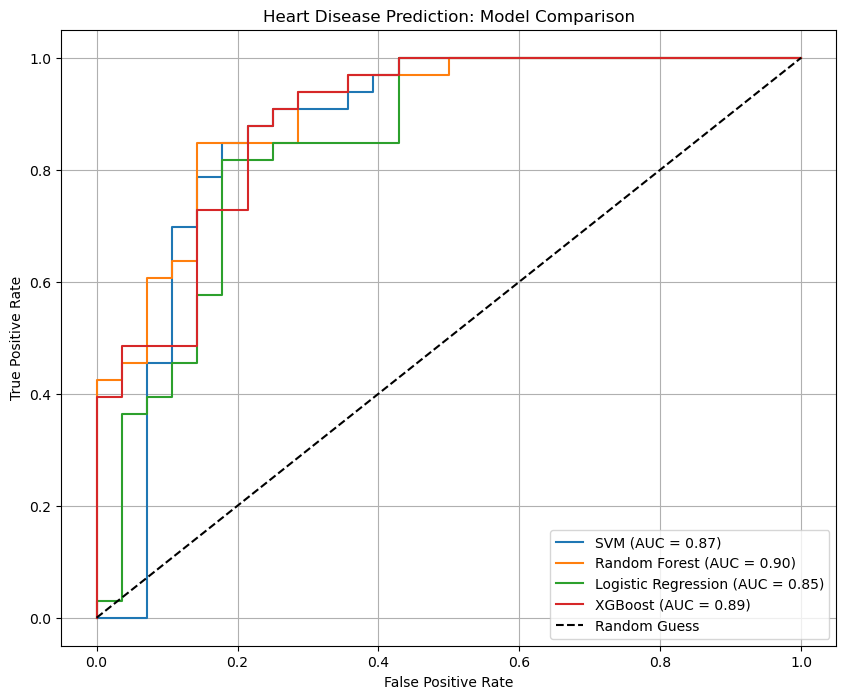


🏆 Best Model: Random Forest
AUC: 0.90
Classification Report:
                  precision    recall  f1-score   support

No Heart Disease       0.87      0.71      0.78        28
   Heart Disease       0.79      0.91      0.85        33

        accuracy                           0.82        61
       macro avg       0.83      0.81      0.81        61
    weighted avg       0.83      0.82      0.82        61


💾 Saved best model as 'best_heart_model.sav'

🩺 Example Clinical Prediction:

Input Features:
Chest Pain: Type 2
Heart Rate: 173 bpm
Exercise Angina: No
ST Depression: 0mm
Blocked Vessels: 4

Clinical Assessment:
Prediction: Heart Disease
Probability: 93.4%
Risk Factors: Chest pain type 2, 4 blocked vessel(s)
Recommended Action: Immediate angiogram


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, classification_report, 
                           roc_auc_score, roc_curve, confusion_matrix)
from sklearn.preprocessing import StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

# ====================== DATA PREPARATION ======================
def load_data():
    """Load and preprocess heart disease dataset"""
    df = pd.read_csv("C:\\Users\\khade\\OneDrive\\Desktop\\Capstone\\heart.csv")
    # Selected features (5 key clinical attributes)
    X = df[['cp', 'thalach', 'exang', 'oldpeak', 'ca']]
    y = df['target']
    return X, y

# ====================== MODEL TRAINING ======================
def train_models(X_train, y_train):
    """Train and compare multiple models with optimal settings"""
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Model configurations
    models = {
        "SVM": SVC(kernel='rbf', C=1, gamma='scale', probability=True, random_state=42),
        "Random Forest": RandomForestClassifier(n_estimators=150, max_depth=5, random_state=42),
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42)
    }
    
    # Train all models
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        trained_models[name] = model
    
    return trained_models, scaler

# ====================== EVALUATION ======================
def evaluate_models(models, X_test, y_test, scaler):
    """Compare model performance with ROC curves and metrics"""
    plt.figure(figsize=(10, 8))
    X_test_scaled = scaler.transform(X_test)
    results = {}
    
    for name, model in models.items():
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)[:, 1]
        
        # Store metrics
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_proba),
            'report': classification_report(y_test, y_pred, target_names=["No Heart Disease", "Heart Disease"])
        }
        
        # Plot ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {results[name]["auc"]:.2f})')
    
    # Format plot
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Heart Disease Prediction: Model Comparison')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()
    
    return results

# ====================== CLINICAL PREDICTION ======================
def predict_heart_disease(model, scaler, cp, thalach, exang, oldpeak, ca, threshold=0.3):
    """Make clinically interpretable predictions"""
    input_data = scaler.transform([[cp, thalach, exang, oldpeak, ca]])
    proba = model.predict_proba(input_data)[0][1]
    
    # Risk factors
    risks = []
    if cp >= 2: risks.append(f"Chest pain type {cp}")
    if thalach < 140: risks.append(f"Low HR ({thalach}bpm)")
    if exang == 1: risks.append("Exercise angina")
    if oldpeak > 1: risks.append(f"ST depression ({oldpeak}mm)")
    if ca > 0: risks.append(f"{ca} blocked vessel(s)")
    
    return {
        'prediction': "Heart Disease" if proba >= threshold else "No Heart Disease",
        'probability': f"{proba:.1%}",
        'risk_factors': ", ".join(risks) if risks else "No significant risks",
        'action': "Routine check" if proba < 0.3 else 
                 "Stress test" if proba < 0.7 else 
                 "Immediate angiogram"
    }

# ====================== MAIN EXECUTION ======================
if __name__ == "__main__":
    # Load data
    X, y = load_data()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    
    # Train and compare models
    print("🚀 Training models...")
    models, scaler = train_models(X_train, y_train)
    
    print("\n📊 Model Comparison Results:")
    results = evaluate_models(models, X_test, y_test, scaler)
    
    # Print metrics for best model
    best_model_name = max(results, key=lambda x: results[x]['auc'])
    print(f"\n🏆 Best Model: {best_model_name}")
    print(f"AUC: {results[best_model_name]['auc']:.2f}")
    print("Classification Report:")
    print(results[best_model_name]['report'])
    
    # Save best model (CHANGED TO .sav EXTENSION)
    with open('best_heart_model.sav', 'wb') as f:
        pickle.dump({
            'model': models[best_model_name],
            'scaler': scaler,
            'metadata': {
                'features': ['cp', 'thalach', 'exang', 'oldpeak', 'ca'],
                'auc': results[best_model_name]['auc']
            }
        }, f)
    print("\n💾 Saved best model as 'best_heart_model.sav'")
    
    # Example clinical prediction
    print("\n🩺 Example Clinical Prediction:")
    case = {'cp': 2, 'thalach': 173, 'exang': 0, 'oldpeak': 0, 'ca': 4}
    pred = predict_heart_disease(models[best_model_name], scaler, **case)
    
    print(f"\nInput Features:")
    print(f"Chest Pain: Type {case['cp']}")
    print(f"Heart Rate: {case['thalach']} bpm")
    print(f"Exercise Angina: {'Yes' if case['exang'] else 'No'}")
    print(f"ST Depression: {case['oldpeak']}mm")
    print(f"Blocked Vessels: {case['ca']}")
    
    print(f"\nClinical Assessment:")
    print(f"Prediction: {pred['prediction']}")
    print(f"Probability: {pred['probability']}")
    print(f"Risk Factors: {pred['risk_factors']}")
    print(f"Recommended Action: {pred['action']}")